In [ ]:
import ee
# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AfJohXnJi7kLqbr69BcbD8YKNBddSh0IiBL4HlBcjSc4iXzBMt57HgNaypc



Successfully saved authorization token.


#Import librairies

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

#set random seed
seed = 0

# Load data

In [ ]:
sampled_points = ee.FeatureCollection('projects/ee-geoinfproj/assets/Geoinf/Table_Merged_Points_Stratified_World').getInfo()['features']
concat_points = pd.json_normalize(sampled_points)
print(concat_points.head(1))
data = concat_points.rename(columns = {  'properties.Burn' : 'class',
    'properties.HumanImpactIndexMean' : 'hii',
    'properties.LandCover' : 'landcover',
    'properties.NDMI' : 'ndmi',
    'properties.NDVI' : 'ndvi',
    'properties.aspect' : 'aspect',
    'properties.precipitation' : 'precipitation',
    'properties.slope' : 'slope',
    'properties.soil_moist' : 'soil_moist',
    'properties.temp_max': 'temp_max',
    'properties.temp_min' : 'temp_min',
    'properties.water_deficit' : 'water_deficit',
    'properties.wind_speed' : 'wind_speed',})


data = data[['aspect','hii','landcover','ndmi','ndvi', 'precipitation', 'slope', 'soil_moist', 'temp_max', 'temp_min', 'water_deficit', 'wind_speed', 'class']]

data['class'].value_counts()

      type                    id geometry.type  \
0  Feature  000000000000000000c8         Point   

                      geometry.coordinates  properties.Burn  \
0  [12.351834772874579, 58.16591429887882]                0   

   properties.HumanImpactIndexMean  properties.LandCover  properties.NDMI  \
0                      1734.900024                     1          0.34682   

   properties.NDVI  properties.aspect  properties.precipitation  \
0         0.584347         333.769409                      70.0   

   properties.slope  properties.soil_moist  properties.temp_max  \
0          0.050487                  744.0                108.0   

   properties.temp_min  properties.water_deficit  properties.wind_speed  
0                 39.0                  0.018692             327.291667  


class
0    650
1    601
Name: count, dtype: int64

# Rebalancing dataset

In [ ]:
myrng = np.random.default_rng(seed=seed)
myrdarray = myrng.integers(low = 0, high = unburned_points_df.shape[0], size = burned_points_df.shape[0], dtype = int)

reshaped_unburned = unburned_points_df.iloc[myrdarray]

concat_reshaped = pd.concat([burned_points_df, reshaped_unburned], ignore_index=True)

reshaped_data = concat_reshaped.rename(columns={'properties.Aspect':'aspect',
                     'properties.HumanImpactIndexMean':'hii',
                     'properties.LandCover':'landcover' ,
                     'properties.NDMI':'ndmi',
                     'properties.NDVI':'ndvi',
                     'properties.Precipitation':'precipitation' ,
                     'properties.Slope':'slope' ,
                     'properties.SoilMoist' : 'soil_moist' ,
                     'properties.TempMax' : 'temp_max' ,
                     'properties.TempMin' :'temp_min',
                     'properties.WaterDeficit' : 'water_deficit',
                     'properties.WindSpeed' : 'wind_speed',
                     'properties.sum' : 'class'})

reshaped_data = reshaped_data[['aspect','hii','landcover','ndmi','ndvi', 'precipitation', 'slope', 'soil_moist', 'temp_max', 'temp_min', 'water_deficit', 'wind_speed', 'class']]

print('before reshape' , data['class'].value_counts())
print('after reshape', reshaped_data['class'].value_counts())

before reshape class
1    484
0    401
Name: count, dtype: int64
after reshape class
1    484
0    484
Name: count, dtype: int64


In [ ]:
# Assuming you have loaded your data into pandas DataFrame (data)
mydata = reshaped_data

X = mydata.drop('class', axis=1)
y = mydata['class']  #'class' is the target variable

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Training the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluating the Model
y_pred = rf_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Interpreting the Results
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)
print(feature_importances)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.9896907216494846
               importance
ndvi             0.259687
soil_moist       0.167447
wind_speed       0.124110
landcover        0.119475
precipitation    0.088898
water_deficit    0.073965
ndmi             0.046415
temp_min         0.041657
hii              0.029551
temp_max         0.023892
slope            0.015589
aspect           0.009314
Confusion Matrix:
[[101   1]
 [  1  91]]


# PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Principal component analysis is affected by attribute scale so we normalize all the attributes by eliminating the mean and scaling to unit variance
x = StandardScaler().fit_transform(X)
n_pca = X.shape[1]
mypca = PCA(n_components=n_pca, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=seed)
new_data = mypca.fit_transform(x)
pca_data = pd.DataFrame(data = new_data, columns = ['pc'+str(i+1) for i in range(n_pca)])
pca_data['class'] = data['class']
pca_data

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,class
0,2.095079,1.056968,-0.243771,-0.856604,-1.940308,0.577605,1.892146,-0.569734,0.318241,0.606272,0.264728,-0.175221,0
1,2.145485,1.069526,-0.553528,-0.789729,-1.042081,0.422576,1.748516,-0.445314,0.370230,0.508394,0.245006,-0.195166,0
2,2.051274,0.964870,-1.160659,-1.457488,0.295046,0.188112,1.208951,-0.184342,0.032666,0.203753,0.227453,-0.250066,0
3,2.059624,1.574706,-1.269498,-0.400490,1.044150,-2.330581,2.860973,-0.712954,0.080080,0.414243,-0.218332,0.045088,0
4,1.733531,1.874944,-2.633658,1.145631,-0.172933,1.639380,0.341155,-0.262295,0.084970,0.313795,0.036613,-0.093033,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246,2.987073,-1.812424,1.392482,1.565701,0.495667,-2.365488,-0.306375,3.008724,1.483713,-1.212437,0.790861,-0.084568,0
1247,3.657840,-1.905913,1.443675,3.350351,-0.668706,-2.239946,0.242339,3.300656,2.033241,-1.326559,1.143228,-0.001084,0
1248,2.854224,-0.919183,1.543554,2.668798,2.034003,-1.262474,-0.062991,2.261119,0.065927,-0.138122,0.221531,-0.092206,0
1249,1.130861,2.486055,1.294218,0.514141,0.619482,-1.254832,-0.849650,0.272029,-0.263906,0.343046,0.168448,-0.133146,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


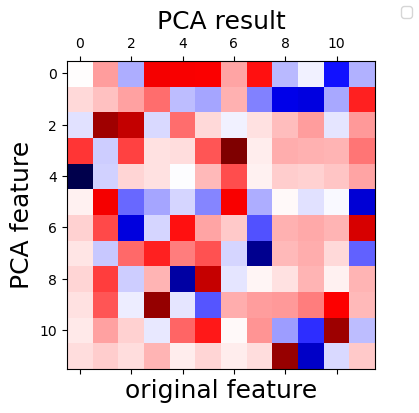

In [ ]:
pcs = mypca.components_

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(pcs, cmap='seismic')

plt.xlabel('original feature', fontsize=18)
plt.ylabel('PCA feature', fontsize=18)
plt.title('PCA result', fontsize=18)
fig.legend()
plt.show()


In [ ]:
# Assuming you have loaded your data into pandas DataFrame (data)
mydata = pca_data
X = mydata.drop('class', axis=1)
y = mydata['class']  #'class' is the target variable

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluating the Model
y_pred = rf_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Interpreting the Results
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)
print(feature_importances)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.701195219123506
      importance
pc1     0.103537
pc11    0.102431
pc2     0.098119
pc6     0.097604
pc4     0.087990
pc7     0.082340
pc10    0.075084
pc9     0.074980
pc8     0.072754
pc12    0.071393
pc3     0.070099
pc5     0.063672
Confusion Matrix:
[[103  36]
 [ 39  73]]
